<a href="https://colab.research.google.com/github/dirudiez/TFM_DiegoRudiez/blob/main/ClasificadorBinario_efficientnet_b3_BalanceoSklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&color_mode=auto&commit=550a08945499aa9ff119547dc4aefbbeec0e5dbf&device=unknown&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f77616c6b776974686661737461692f77616c6b776974686661737461692e6769746875622e696f2f353530613038393435343939616139666631313935343764633461656662626565633065356462662f6e62732f30325f766973696f6e2e65787465726e616c2e74696d6d2e6970796e62&logged_in=false&nwo=walkwithfastai%2Fwalkwithfastai.github.io&path=nbs%2F02_vision.external.timm.ipynb&platform=android&repository_id=295613905&repository_type=Repository&version=98

En este cuaderno probaremos la arquitectura efficientnet_b3 para ver si obtenemos unos mejores resultados.

## Efficientnet_b3

In [ ]:
!pip install fastai -Uq
!pip install timm

#Reiniciamos el entorno de ejecución automáticamente
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

In [ ]:
from fastai.vision.all import *

In [ ]:
!pip install wwf
!pip install nbdev

In [ ]:
from wwf.utils import *
from wwf.vision.timm import *

## Dataset

En este caso estamos usando el dataset que ha sido preprocesados mediante el método de recorte

In [ ]:
!wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
!wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
!wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip

2022-06-16 06:43:48 URL:https://uccc564464db9f7d5cd37baa4d62.dl.dropboxusercontent.com/cd/0/inline2/BnQBbu-PiSgNYZt8-hlQCV3_5xzGoobwzQ466TDzmU6S4hwHE-GxXx7XbtJ8eEfmkkD7giQ1tTmQBoGcvdJpK1r8mOqdntviwUEZg6YFw5UgDWG_T5F4GvZABF5Qv8oRph9vkvkow7XEFPiPzaLyNFg3G1swafhT1nBp_g5XterkEfY8aXMHlqyOMIgNlsynxdWtAHjl9eVYhZROVI23E8IkDT1fAq-lk2dOHiNgT7l68b92TYBkvDH_pcJihKPz5DDnEvnGputUwFJJuRDLXawhC1jWX6PP3gdNbiCN1qzdS0oa5NPXXLiKMVaPyKInwaecHhjPyl7YX0PVLtOMBxHnNeWdn-AG0MERiZMYqCJ1tRQBIoYMGahdbr8L0kLXD2uA8DgVLjVrKr-UDhiD3v2V72zpPf2JWVLt29IDphYX2A/file [138777773/138777773] -> "train.zip" [1]
2022-06-16 06:43:50 URL:https://ucadf0e2e80f9c78c0bbe7863329.dl.dropboxusercontent.com/cd/0/inline2/BnSpejK07GowYRgkTZDb1oHeTHPqCQDebRILkHkd7__dtC3TWZjtXzz5YnCmgvCdTMrG0nOtZEFKkIYPjIIB5ISwFnfjbdCrFhOqpVt3dFo0393ZDswnraxsFPZI4ifrV6hwjEBOFXaLyXIxJGhmFh6R0N3KM0JilxuyfpUKTMZMMRcaZHET0lu4rBzS3fpfeeIS9MKtRVp0JmMKD9M-mvILpM9geegRSO9tIYD3IKD7wCHt7epBBA_YMc3WTKcpGDfAinw7lf4Pj2o3GMiTWwD4dSgJZJrpiXhvRcKVhSfOwj5jLqSrmrOm3S5EyTVThGg

In [ ]:
# !rm -rvf Training_Set_Pre
!unzip -qq train.zip #-qq no verbose
!unzip -qq test.zip
!unzip -qq val.zip

In [ ]:
#Método para crear estructura de directorios
def crearEstructura(nombreDataset, clases):
  !mkdir "$nombreDataset"
  !mkdir "$nombreDataset"/test
  !mkdir "$nombreDataset"/train
  !mkdir "$nombreDataset"/val
  for x in clases:
    !mkdir "$nombreDataset"/train/"$x"
    !mkdir "$nombreDataset"/test/"$x"
    !mkdir "$nombreDataset"/val/"$x"

In [ ]:
crearEstructura('dataset', ['normal', 'enfermedad'])

In [ ]:
trainPath = Path('Training_Set_Pre/')
testPath  = Path('Test_Set_Pre/')
valPath  =  Path('Evaluation_Set_Pre/')

In [ ]:
df_train = pd.read_csv(str(trainPath) + '/train.csv')
df_test = pd.read_csv(str(testPath) + '/test.csv')
df_val = pd.read_csv(str(valPath) + '/val.csv')

#### Mover imágenes:

In [ ]:
import shutil

def moverImg(df, pathO, pathD):
  for id, enf in zip(df['ID'], df['Disease_Risk']):
    if(int(enf)==0):
        shutil.move(pathO + '/' + str(id) + '.png', pathD + '/normal')
    else:
        shutil.move(pathO + str(id) + '.png', pathD + '/enfermedad')

In [ ]:
path = Path('dataset')

In [ ]:
moverImg(df_train, str(trainPath) + '/Training/', str(path)  + '/train')
moverImg(df_test, str(testPath) + '/Test/', str(path)  + '/test')
moverImg(df_val, str(valPath) + '/Validation/', str(path)  + '/val')

## Cargando el dataset

In [ ]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(train_name='train', valid_name='val'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))

In [ ]:
dls = db.dataloaders(path,bs=128)

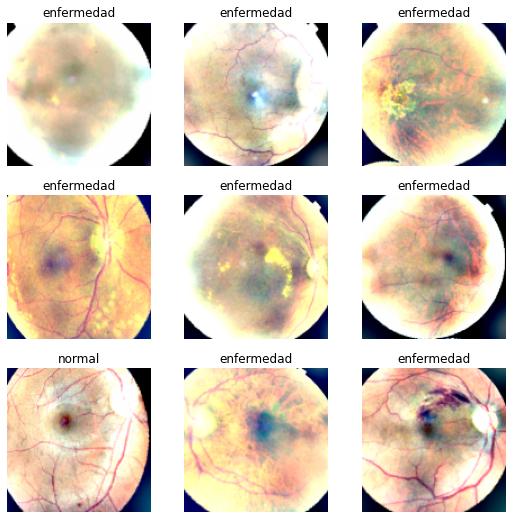

In [ ]:
dls.show_batch()

In [ ]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=20),
    SaveModelCallback()  
]

In [ ]:
learn = timm_learner(dls, 'efficientnet_b3', metrics=[error_rate, accuracy], cbs=callbacks)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra2-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_ra2-cf984f9c.pth


SuggestedLRs(minimum=0.014454397559165954, steep=1.5848931980144698e-06, valley=0.001737800776027143, slide=0.009120108559727669)

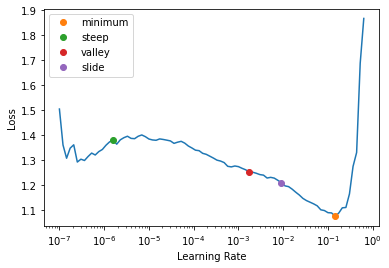

In [ ]:
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

## Entrenamos el modelo

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.183753,1.029123,0.276563,0.723437,00:15


Better model found at epoch 0 with valid_loss value: 1.0291234254837036.


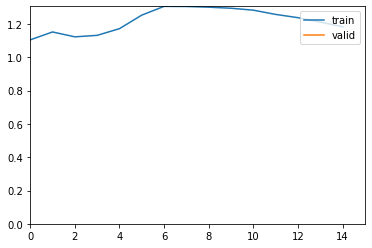

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.572794,0.479494,0.190625,0.809375,00:12
1,0.533336,0.468919,0.210938,0.789062,00:12
2,0.486006,0.398402,0.181250,0.818750,00:12
3,0.453224,0.377901,0.165625,0.834375,00:12
4,0.428676,0.409427,0.196875,0.803125,00:12
5,0.414956,0.386583,0.170312,0.829687,00:12
6,0.397914,0.392326,0.168750,0.831250,00:12
7,0.388892,0.365511,0.160938,0.839063,00:12
8,0.388120,0.392901,0.179688,0.820312,00:12
9,0.379259,0.333841,0.156250,0.843750,00:12


Better model found at epoch 0 with valid_loss value: 0.47949400544166565.


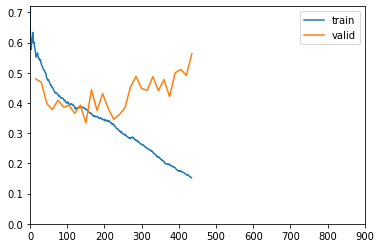

Better model found at epoch 1 with valid_loss value: 0.4689192771911621.
Better model found at epoch 2 with valid_loss value: 0.39840173721313477.
Better model found at epoch 3 with valid_loss value: 0.3779013752937317.
Better model found at epoch 7 with valid_loss value: 0.3655109405517578.
Better model found at epoch 9 with valid_loss value: 0.33384108543395996.
No improvement since epoch 9: early stopping


In [ ]:
learn.fine_tune(60,base_lr=3e-2)

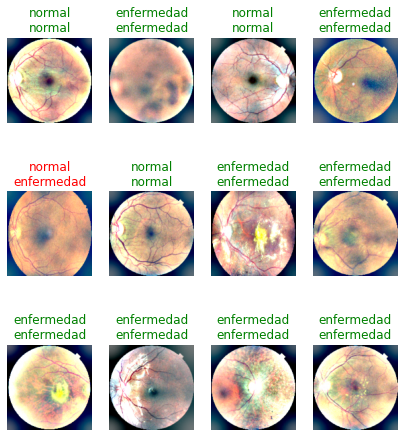

In [ ]:
learn.show_results(max_n=12, figsize=(7,8))

## Evaluando el Modelo

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))
dlsTest = dbTest.dataloaders(path,bs=128)

In [ ]:
learn.dls = dlsTest

Obtenemos una accuracy de 0.875, no está nada mal.

In [ ]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.125.


(#3) [0.3128979504108429,0.125,0.875]

Exportamos el modelo:

In [ ]:
learn.to_fp32()
learn.export('modeloBinario_efficientnet_b3.pkl')